# Sommaire :
 
**<a href="#C1"> I.) CREATION DE DATAFRAME PERIODIQUE </a>**
  - <a href ="#C11"> 1.1) Dataframe commande </a>
  - <a href ="#C12"> 1.2) Dataframe clients </a>
  - <a href ="#C13"> 1.3) Evolution des commandes et clients </a>
 
 
**<a href="#C2"> II.) MODELISATION </a>**

 
**<a href="#C3"> III.) EVALUATION DE LA STABILITE </a>**
 - <a href ="#C31"> 3.1.) Calcul de Ari score </a>
 - <a href ="#C31"> 3.2.)  Evolution du ARI </a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA = pd.read_csv('DATA.csv')
DATA.head()

,customer_unique_id,customer_state,order_count,total_spent,average_score,large,medium,small,Automotive_Industry,Beauty_Health_Wellness,DIY_Garden_Pets,Home_Cooking,IT_office,Others_categories,Sports_Leisures,Toy_Children_Babies
0,871766c5855e863f6eccc05f988b23cb,RJ,1,72.19,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,eb28e67c4c0b83846050ddfb8a35d051,SP,2,284.56,4.5,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,3818d81c6709e39d06b2738a8d3a2474,MG,1,216.87,5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,af861d436cfc08b2c2ddefd0ba074622,SP,1,25.78,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,64b576fb70d441e8f1b2d7d446e483c5,SP,1,218.04,5.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [3]:
data = pd.read_csv('data_Order')
data.head()

,order,customer_unique_id,customer_state,seller_id,product_id,product_size,product_category,order_status,payment_value,score,order_approved_Date
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,RJ,48436dade18ac8b2bce089ec2a041202,4244733e06e7ecb4970a6e2683c13e61,small,Others_categories,delivered,72.19,5.0,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,SP,dd7ddc04e1b6c2c614352b383efe2d36,e5f2d52b802189ee658865ca93d83a8f,large,DIY_Garden_Pets,delivered,259.83,4.0,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,MG,5b51032eddd242adc84c38acab88f23d,c777355d18b72b67abbeef9df44fd0fd,small,Home_Cooking,delivered,216.87,5.0,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,SP,9d7a1d34a5052409006425275ba1c2b4,7634da152a4610f1595efa32f14722fc,small,Beauty_Health_Wellness,delivered,25.78,4.0,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,SP,df560393f3a51e74553ab94004ba5c87,ac6c3623068f30de03045865e4e10089,small,DIY_Garden_Pets,delivered,218.04,5.0,2017-02-04


In [4]:
data.shape

(99401, 11)

Nous allons faire l'entrainement du modèle pour différentes périodes

# <a name="C1"> I.) CREATION DE DATAFRAME PERIODIQUE <a/>

In [5]:
from datetime import datetime, timedelta

# Conversion de la colonne "date" en type de données "datetime"
data['order_approved_Date'] = pd.to_datetime(data['order_approved_Date'])

date_debut = data['order_approved_Date'].min()
date_fin = data['order_approved_Date'].max()

#### Créer une fonction calculant la période en mois

In [6]:
from datetime import date

def difference_dates_en_mois(date_debut, date_fin):
    annees = date_fin.year - date_debut.year
    mois = date_fin.month - date_debut.month
    jours = date_fin.day - date_debut.day

    # Gestion du dépassement des mois
    if jours < 0:
        mois -= 1

    # Gestion du dépassement des années
    if mois < 0:
        annees -= 1
        mois += 12

    # Calcul du nombre total de mois
    total_mois = annees * 12 + mois
    return total_mois

# Exemple d'utilisation

difference_mois = difference_dates_en_mois(date_debut, date_fin)
print("Date de début :", date_debut)
print("Date de fin :", date_fin)
print ("Nombre de mois :", difference_mois + 1)

Date de début : 2016-10-04 00:00:00
Date de fin : 2018-08-29 00:00:00
Nombre de mois : 23


## <a name="C11"> 1.1) Dataframe commande <a/>

In [7]:
from datetime import datetime, timedelta
Nb_month = 15

# Conversion de la colonne "date" en type de données "datetime"
data['order_approved_Date'] = pd.to_datetime(data['order_approved_Date'])

# Tri du DataFrame par la colonne "date"
data = data.sort_values('order_approved_Date')

# Filtrage des clients
date_debut = data['order_approved_Date'].min()
date_fin = date_debut + pd.DateOffset(months = Nb_month)
data = data[(data['order_approved_Date'] >= date_debut) & (data['order_approved_Date'] <= date_fin)]

# Affichage du DataFrame filtré
data.head()

,order,customer_unique_id,customer_state,seller_id,product_id,product_size,product_category,order_status,payment_value,score,order_approved_Date
76064,c3d9e402b6a0fbe2a5f7fc5b41117c38,9f302d00dd3e18ed3745778184b4f0fe,PA,624f4ece8da4aafb77699233d480f8ef,817e1c2d22418c36386406ccacfa53e8,small,Home_Cooking,delivered,237.45,5.0,2016-10-04
79711,cd3b8574c82b42fc8129f6d502690c3e,87776adb449c551e74c13fc34f036105,SP,b499c00f28f4b7069ff6550af8c1348a,e2a1d45a73dc7f5a7f9236b043431b89,medium,Beauty_Health_Wellness,delivered,40.95,5.0,2016-10-04
47278,79ffdd52a918bbe867895a4b183d6457,8d36e7e56a9f8044df728e9cbf5a3eaf,MG,c7dcd301ecfe5ab7f778ac172cf74be7,5691a536d459e5cb326b7bedce928067,medium,Home_Cooking,delivered,319.00,1.0,2016-10-04
38500,63638a6806d67773f3adba8534553fff,df2988ba3ed226b10521a0e4da849b61,RJ,b335c59ab742f751a85db9c411a86739,85b99d83c60cab5b4d8f927ad35212a1,small,Home_Cooking,delivered,86.88,5.0,2016-10-04
92890,ef1b29b591d31d57c0d7337460dd83c9,10e89fd8e5c745f81bec101207ba4d7d,MG,cca3071e3e9bb7d12640c9fbe2301306,bfce5e847034e1fbbc1ed0bff6a372c7,small,Home_Cooking,delivered,92.27,1.0,2016-10-04


In [8]:
data.shape

(45890, 11)

## <a name="C12"> 1.2) Dataframe clients <a/>

### a.) nv1

In [9]:
# Calcul de la moyenne de satisfaction pour chaque client
average_score = data.groupby('customer_unique_id')['score'].mean().reset_index()
average_score.columns = ['customer_unique_id', 'average_score']

In [10]:
count_score = data.groupby('customer_unique_id')['score'].count().reset_index()
count_score.columns = ['customer_unique_id', 'count_score']

In [11]:
# Fusion des DataFrames pour obtenir la table RFM
nv1 = average_score.merge(count_score,on='customer_unique_id')
nv1.head()

,customer_unique_id,average_score,count_score
0,0000f46a3911fa3c0805444483337064,3.0,1
1,0000f6ccb0745a6a4b88665a16c9f078,4.0,1
2,0004aac84e0df4da2b147fca70cf8255,5.0,1
3,0005e1862207bf6ccc02e4228effd9a0,4.0,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,3.0,1


### b.) nv2

In [12]:
state = data.loc[:, ['customer_unique_id','customer_state']]
# supprimer les doublons
state.drop_duplicates('customer_unique_id', inplace=True, ignore_index=True)

In [13]:
# Calcul de la date maximale de commande pour chaque client
recency_df = data.groupby('customer_unique_id')['order_approved_Date'].max().reset_index()
recency_df.columns = ['customer_unique_id', 'last_order_date'] # changement de nom des colonnes

# Calcul du nombre de commandes pour chaque client
frequency_df = data.groupby('customer_unique_id')['order_approved_Date'].count().reset_index()
frequency_df.columns = ['customer_unique_id', 'order_count']

# Calcul du montant total dépensé pour chaque client
monetary_df = data.groupby('customer_unique_id')['payment_value'].sum().reset_index()
monetary_df.columns = ['customer_unique_id', 'total_spent']

# Fusion des DataFrames pour obtenir la table RFM
rfm_table = recency_df.merge(frequency_df, on='customer_unique_id').merge(monetary_df, on='customer_unique_id')

# Modifier les type des colonnes de date en type datetime
rfm_table['last_order_date'] = pd.to_datetime(rfm_table['last_order_date'])
# Calcul de la valeur R (Recency)
max_date = rfm_table['last_order_date'].max()
rfm_table['recency'] = (max_date - rfm_table['last_order_date']).dt.days

In [14]:
nv2 = state.merge(rfm_table, on='customer_unique_id')
nv2 = nv2.drop(['last_order_date', 'recency'],axis=1)
nv2.head()

,customer_unique_id,customer_state,order_count,total_spent
0,9f302d00dd3e18ed3745778184b4f0fe,PA,1,237.45
1,87776adb449c551e74c13fc34f036105,SP,1,40.95
2,8d36e7e56a9f8044df728e9cbf5a3eaf,MG,1,319.00
3,df2988ba3ed226b10521a0e4da849b61,RJ,1,86.88
4,10e89fd8e5c745f81bec101207ba4d7d,MG,1,92.27


### c.) nv3

In [15]:
# Pivoter les valeur de catégorie en colonnes
prod=data.pivot_table(index='customer_unique_id',columns='product_category', values='order_status', aggfunc='count')
prod_cat = prod.reset_index()

# Remplacer les valeurs NaN par 0
prod_cat = prod_cat.fillna(0)

In [16]:
# Pivoter les valeur de taille en colonnes
prod=data.pivot_table(index='customer_unique_id',columns='product_size', values='order_status', aggfunc='count')
prod_size = prod.reset_index()

# Remplacer les valeurs NaN par 0
prod_size[['small', 'large', 'medium']] = prod_size[['small', 'large', 'medium']].fillna(0)

In [17]:
nv3 = pd.merge(prod_size,prod_cat, on = 'customer_unique_id')
nv3.head()

,customer_unique_id,large,medium,small,Automotive_Industry,Beauty_Health_Wellness,DIY_Garden_Pets,Home_Cooking,IT_office,Others_categories,Sports_Leisures,Toy_Children_Babies
0,0000f46a3911fa3c0805444483337064,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0004aac84e0df4da2b147fca70cf8255,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Fusion

In [18]:
data = nv2.merge(nv1, on = 'customer_unique_id').merge(nv3, on = 'customer_unique_id')

data = data.drop(['customer_state','count_score'], axis=1)
data.head()

,customer_unique_id,order_count,total_spent,average_score,large,medium,small,Automotive_Industry,Beauty_Health_Wellness,DIY_Garden_Pets,Home_Cooking,IT_office,Others_categories,Sports_Leisures,Toy_Children_Babies
0,9f302d00dd3e18ed3745778184b4f0fe,1,237.45,5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,87776adb449c551e74c13fc34f036105,1,40.95,5.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8d36e7e56a9f8044df728e9cbf5a3eaf,1,319.00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,df2988ba3ed226b10521a0e4da849b61,1,86.88,5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,10e89fd8e5c745f81bec101207ba4d7d,1,92.27,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
data.shape

(42720, 15)

## <a name="C13"> 1.3) Evolution des commandes et clients <a/>

In [20]:
Evolution = ({'Période':['M12', 'M15', 'M18', 'M19', 'M20', 'M23'],
              'Nbre commande':[27903, 45890, 67295, 74437, 80927, 99401],
              'Nbre client':[26041, 42720, 62654, 69260, 75314, 92444]  
            })

In [21]:
# Créer une DataFrame
df = pd.DataFrame(Evolution, columns=['Période', 'Nbre commande', 'Nbre client'])

# Ajouter des colonnes
df["Taux commande"] = (df["Nbre commande"]*100/df["Nbre commande"].max()).round(2)
df["Taux client"] = (df["Nbre client"]*100/df["Nbre client"].max()).round(2)
df

,Période,Nbre commande,Nbre client,Taux commande,Taux client
0,M12,27903,26041,28.07,28.17
1,M15,45890,42720,46.17,46.21
2,M18,67295,62654,67.70,67.78
3,M19,74437,69260,74.89,74.92
4,M20,80927,75314,81.41,81.47
5,M23,99401,92444,100.00,100.00


# <a name="C2"> II.) MODELISATION <a/>

### Standardisation : Centrer et réduire les données 

In [22]:
# Supprimer la colonnes non numérique
X = data.drop('customer_unique_id', axis=1)

In [23]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# On le transforme en DataFrame : 
X_scaled = pd.DataFrame(X_scaled)

X_scaled.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,42720.00,42720.00,42720.00,42720.00,42720.00,42720.00,42720.00,42720.00,42720.00,42720.00,42720.00,42720.00,42720.00,42720.00
mean,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.22,-0.62,-2.53,-0.16,-0.35,-1.93,-0.24,-0.48,-0.26,-0.54,-0.46,-0.27,-0.29,-0.33
25%,-0.22,-0.42,-0.14,-0.16,-0.35,0.14,-0.24,-0.48,-0.26,-0.54,-0.46,-0.27,-0.29,-0.33
50%,-0.22,-0.25,0.66,-0.16,-0.35,0.14,-0.24,-0.48,-0.26,-0.54,-0.46,-0.27,-0.29,-0.33
75%,-0.22,0.05,0.66,-0.16,-0.35,0.14,-0.24,-0.48,-0.26,1.35,-0.46,-0.27,-0.29,-0.33
max,20.42,50.77,0.66,29.17,8.77,14.69,24.61,13.06,14.57,14.58,14.23,11.30,16.50,18.37


### PCA : Réduction du nombre de variable

Nous allons prendre comme dans les dufferents modèles, n_components = 32

In [24]:
from sklearn.decomposition import PCA
from sklearn import decomposition

n_components = 8
pca = PCA(n_components = n_components)

# Transformer les données en utilisant la méthode "fit_transform()" de l'objet PCA:
pca_data = pca.fit_transform(X_scaled)

data = pd.DataFrame(data=pca_data, columns=['PC{}'.format(i) for i in range(1, n_components+1) ])
data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.406151,0.371202,-0.702080,-0.602863,-0.535207,-0.697682,-0.378044,-0.024098
1,-2.113072,0.288971,0.170036,-0.598941,2.083781,-0.552913,-0.300277,0.073045
2,-1.828138,2.644135,-1.403129,-0.246323,0.917642,-0.689686,-0.624297,0.534856
3,0.339237,0.087212,-0.906321,-0.684435,-0.606880,-0.800637,-0.434800,-0.012490
4,0.534655,0.602567,-1.092591,-0.166382,-0.231191,-0.846749,-0.804780,0.456023


### Export csv

In [25]:
# Exporter le fichier après PCA
data.to_csv(".\data_15",index=False)

### Modélisation 

In [26]:
# Importer le fichier
F0 = pd.read_csv('data_23')

In [27]:
from sklearn.cluster import KMeans
# Utiliser 10 clusters
M0 = KMeans(n_clusters=10, random_state=42)
# entrainer
M0.fit(F0)

KMeans(n_clusters=10, random_state=42)

# <a name="C3"> III.) EVALUATION DE LA STABILITE <a/>

- Générez deux ensembles de données à partir du même jeu de données d'origine (par exemple, en effectuant une légère perturbation sur les points d'origine).

- L'indice ARI varie entre -1 et 1, où une valeur proche de 1 indique une forte similitude entre les deux étiquetages et donc une stabilité élevée de l'algorithme pour les données perturbées.


Nous allons simuler plusieurs périodes et afficher l'évolution ARI score 

## <a name="C31"> 3.1) Calcul de Ari score <a/>

In [28]:
# Importer le fichier
F1 = pd.read_csv('data_15')
F2 = pd.read_csv('data_18')
F3 = pd.read_csv('data_19')
F4 = pd.read_csv('data_20')
F5 = pd.read_csv('data_23')

In [31]:
vf = [F1, F2, F3, F4, F5]

In [32]:
from sklearn.metrics import adjusted_rand_score

# Créer un tableau pour stocker les valeurs d'ARI pour chaque dataset
ari_scores = []

# Boucle sur chaque dataset et effectuer le clustering pour calculer l'ARI
for X in vf:
    # Effectuer le clustering sur les données X
    kmeans = KMeans(n_clusters=10, random_state=42)
    kmean_trained = kmeans.fit(X)
    y_pred = kmean_trained.predict(F0)
    y_true = M0.predict(F0)
    
    ari = adjusted_rand_score(y_true, y_pred)
    ari_scores.append(ari)

In [33]:
ari_scores

[0.722121848489172,
 0.762073625957213,
 0.9935614935992191,
 0.9947862940497519,
 1.0]

## <a name="C32"> 3.2) Evolution du ARI <a/>

In [34]:
ARI = ({'Période':['M15', 'M18', 'M19', 'M20', 'M23'],
        'ARI Score':ari_scores
        })

In [35]:
# Créer une DataFrame
ARI_Evolution = pd.DataFrame(ARI, columns=['Période', 'ARI Score'])
ARI_Evolution['ARI Score'] = (ARI_Evolution['ARI Score']* 100).round(2)
ARI_Evolution

,Période,ARI Score
0,M15,72.21
1,M18,76.21
2,M19,99.36
3,M20,99.48
4,M23,100.00


In [36]:
df = df.loc[:, ["Période", "Taux client" ]]
Evolution = ARI_Evolution.merge(df, on='Période')
Evolution 

,Période,ARI Score,Taux client
0,M15,72.21,46.21
1,M18,76.21,67.78
2,M19,99.36,74.92
3,M20,99.48,81.47
4,M23,100.00,100.00


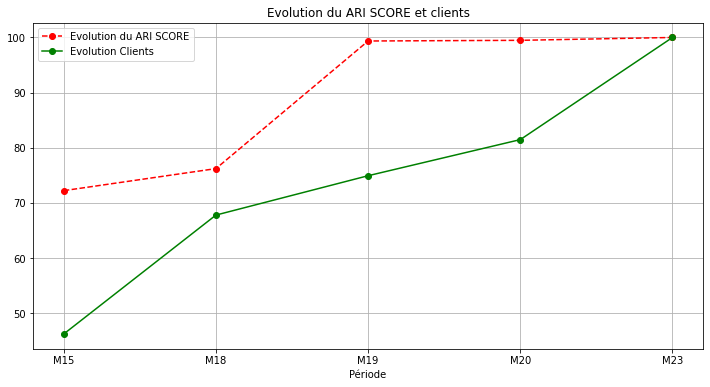

In [37]:
plt.figure(figsize=(12,6))

# Tracer la première courbe (en rouge) avec une légende
plt.plot(Evolution['Période'], Evolution["ARI Score"], 
         label='Evolution du ARI SCORE',  marker='o', color='red', linestyle='--')

# Tracer la deuxième courbe (en vert) avec une légende
plt.plot(Evolution['Période'], Evolution["Taux client"], 
         label='Evolution Clients',  marker='o', color='green', linestyle='-')

# Ajouter une légende au graphique
plt.legend()

# Ajouter un titre aux axes et au graphique
plt.title('Evolution du ARI SCORE et clients')
plt.xlabel('Période')

plt.grid()  # Ajouter des grilles pour une meilleure lisibilité
plt.show()